## Load useful libraries

In [1]:
import pickle
import json
import pprint as pp
import numpy as np

from tensorflow.keras.models import model_from_json

#from plotting_utilities import plot_basic_loss
# instead
import matplotlib.pyplot as plt

2025-01-26 14:59:12.917739: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 14:59:12.947795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 14:59:12.947817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 14:59:12.948599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:59:12.953518: I tensorflow/core/platform/cpu_feature_guar

## Specify which training run we are investigating

In [2]:
application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output/'

In [3]:
# 200 epochs
training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----6f467d3d-510d-44c5-80ab-9c23c9b6801a'
#  BEST training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----798bb099-0e9a-4a21-88c9-a978d48215ea'
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----b0742c6c-52b6-4bf1-b974-8c5266ae2494'

# 500 epochs
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----68d693f4-9cac-4462-b7ab-5407f55fe9d8'

# 300 epochs
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----02fc3bdd-3465-4b4b-9800-56bb936af99a'




    

In [4]:
#filename_history = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'
#filename_config_json = model_training_output_directory + '/' + training_run + '_regressor_config.json'

In [8]:
class ModelResult():
    def __init__(self, model_training_output_directory, training_run):
        self.model_training_output_directory = model_training_output_directory
        self.training_run = training_run
        self.filename_history = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'
        self.filename_config_json = model_training_output_directory + '/' + training_run + '_regressor_config.json'
        self.filename_model_json = model_training_output_directory + '/' + training_run + '_model_regressor.json'
        self.filename_model_final_weights = model_training_output_directory + '/' + training_run + '_final_weights_regressor.pickled'

        self.filename_train_val_test_data = (
            model_training_output_directory 
            + training_run.split('----')[0]
            + '_train_val_test_dict.pickled'
        )

    def fit(self):
        self.load_model()
        self.load_training_run_config()
        self.load_training_history()
        self.load_train_val_test_data()
        self.predict()
        self.compute_error()
    
    def load_model(self):
        with open(self.filename_model_json, 'r') as json_file:
            loaded_model_json = json_file.read()

        # Create a new model from the JSON
        self.model = model_from_json(loaded_model_json)

        # Load the weights into the new model
        self.model.load_weights(self.filename_model_final_weights)

    def load_training_history(self):
        try:
            with open(self.filename_history, 'rb') as ff:
                self.history = pickle.load(ff)
        except Exception as exception:
            print(exception)
            sys.exit(-1)
        
    def load_training_run_config(self):
        with open(self.filename_config_json) as ff:
            self.config = json.load(ff)

    def print_training_run_config(self):
        pp.pprint(self.config)
    
    def print_model_summary(self):
        self.model.summary()

    #
    # Define a function for plotting loss/mse against
    # validation loss/mse per training epoch
    #
    def plot_basic_loss(self, metric_base = 'loss', ylabel = 'Loss'):
        epochs = range(1, len(self.history[metric_base]) + 1)

        plt.figure()
        plt.plot(epochs, self.history[metric_base], '-.', label = ylabel)
        plt.plot(epochs, self.history['val_' + metric_base], '-.', label = 'Validation ' + ylabel)
        plt.xlabel('Training Epoch')
    
        plt.ylabel(ylabel)
        plt.title('Training Run: ' + self.training_run.split('----')[-1] + '\nBatch Size = ' + str(self.config['batch_size']))
    
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    def load_train_val_test_data(self):
        with open(self.filename_train_val_test_data, 'rb') as ff:
            self.train_val_test_dict = pickle.load(ff)

        self.M_test = self.train_val_test_dict['test']['M']
        self.y_test = self.train_val_test_dict['test']['y']
        self.n_test = self.train_val_test_dict['test']['n']
        self.position_test = self.train_val_test_dict['test']['position']

    def predict(self):
        self.y_predicted = self.model.predict(self.M_test)

    def compute_error(self):
        self.error_prediction = np.sum(np.abs(self.y_test - self.y_predicted), axis = 1)
        self.error_prediction_median = np.median(self.error_prediction)

    def plot_error_histogram(self):
        title_data = self.training_run.split('----')[0]
        title_run = self.training_run.split('----')[-1]
        title = 'Training data: ' + title_data + '\n' + 'Training run: ' + title_run
        
        plt.figure()
        plt.hist(self.error_prediction, bins=30, color = 'lightblue', label = 'Error metric distribution across test set')
        plt.axvline(x = self.error_prediction_median, color = 'magenta', label = 'Median')
        plt.xlabel('Count')
        plt.ylabel('Error Metric')
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_a_prediction(
        self,
        index = 5,
        n_y_forward = 15, # get this from somewhere else
        color_known_y = 'purple',
        color_predicted_y = 'magenta',
    ):
        X_all_scaled_index = 0  # this is the index for the main time series we have predicted

        x = self.M_test[index, :, X_all_scaled_index]
        y_known_min = self.y_test[index, 0]
        y_known_max = self.y_test[index, 1]
        y_predicted_min = self.y_predicted[index, 0]
        y_predicted_max = self.y_predicted[index, 1]

        n_full = len(x) + n_y_forward + 1
        xmin = 120. / n_full
        xmax = (120 + n_y_forward) / n_full

        plt.figure()
        plt.plot(x, label = 'Known Past')

        plt.axhline(y = y_known_min, xmin = xmin, xmax=xmax, color = color_known_y, label = 'Known Future')
        plt.axhline(y = y_known_max, xmin = xmin, xmax=xmax, color = color_known_y)

        plt.axhline(y = y_predicted_min, xmin = xmin, xmax=xmax, color = color_predicted_y, label = 'Predicted Future')
        plt.axhline(y = y_predicted_max, xmin = xmin, xmax=xmax, color = color_predicted_y)

        plt.xlim(0, n_full)

        plt.title('Training Run: ' + self.training_run.split('----')[-1] + '\n' + 
                      'Batch Size = ' 
                      + str(self.config['batch_size']) + ', index = ' + str(index) + '\n'
                      + 'Bulk error = ' + str(self.error_prediction_median)
                  )
    
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

In [9]:
model_result = ModelResult(model_training_output_directory, training_run)
model_result.fit()

40/40 [==============================] - 5s 118ms/step


In [ ]:
#model_result.plot_error_histogram()

In [11]:
training_run_list = [
    '57f47108-380d-4e78-aeb9-7ebccd07ec65----6f467d3d-510d-44c5-80ab-9c23c9b6801a',
    '57f47108-380d-4e78-aeb9-7ebccd07ec65----798bb099-0e9a-4a21-88c9-a978d48215ea',
    '57f47108-380d-4e78-aeb9-7ebccd07ec65----b0742c6c-52b6-4bf1-b974-8c5266ae2494',
    '57f47108-380d-4e78-aeb9-7ebccd07ec65----68d693f4-9cac-4462-b7ab-5407f55fe9d8',
    '57f47108-380d-4e78-aeb9-7ebccd07ec65----02fc3bdd-3465-4b4b-9800-56bb936af99a',
]

In [15]:
model_result_list = []
for training_run in training_run_list:
    model_result = ModelResult(model_training_output_directory, training_run)
    model_result.fit()
    model_result_list.append(model_result)

40/40 [==============================] - 6s 118ms/step


In [ ]:
training_run_error_list

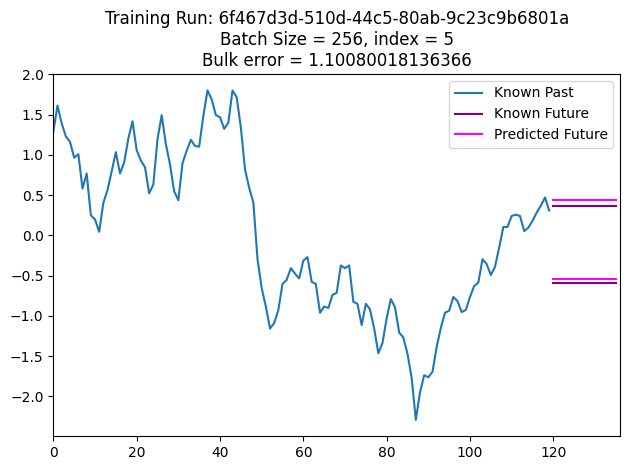

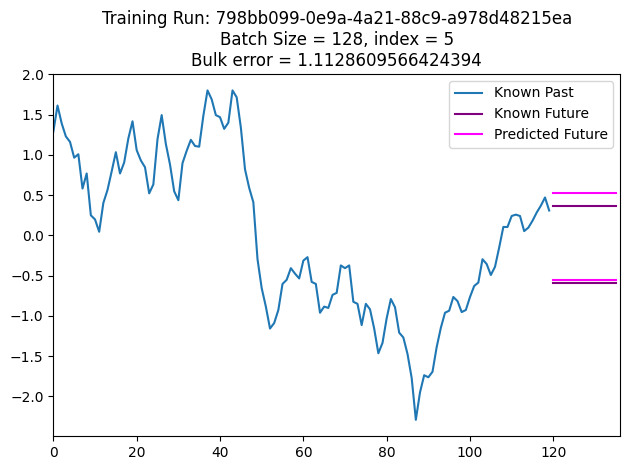

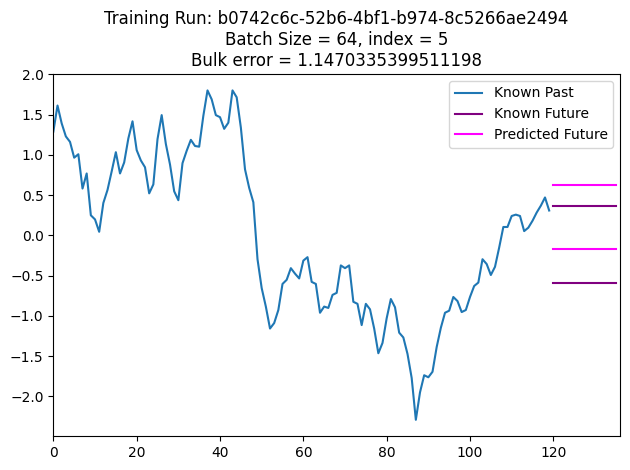

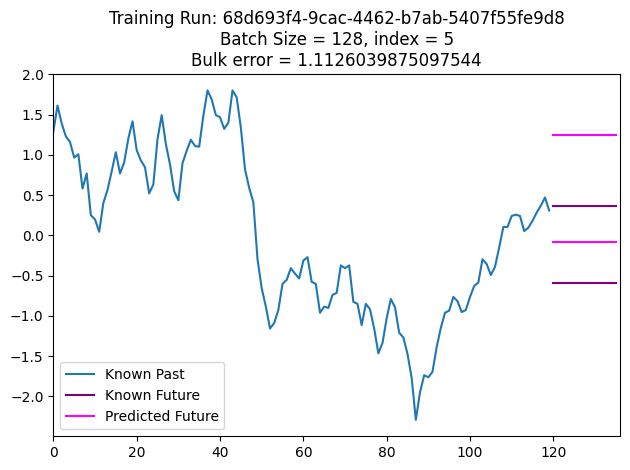

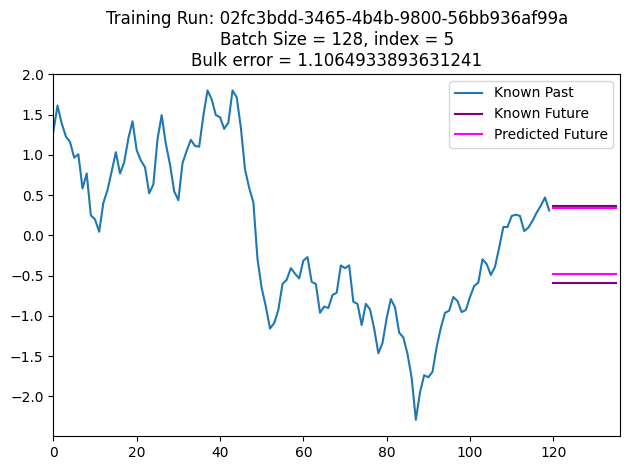

In [17]:
for i, mr in enumerate(model_result_list):
    mr.plot_a_prediction(index = 5)

In [ ]:
model_result.plot_a_prediction(index = 1000)

In [ ]:
model_result.plot_a_prediction(index = 500)

In [ ]:
model_result.plot_a_prediction(index = 700)

In [ ]:
model_result.plot_a_prediction(index = 1200)